In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v7 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-26 11:21:45.823646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:21:45.824233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:21:45.861912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:21:45.862265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:21:45.862560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_043'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

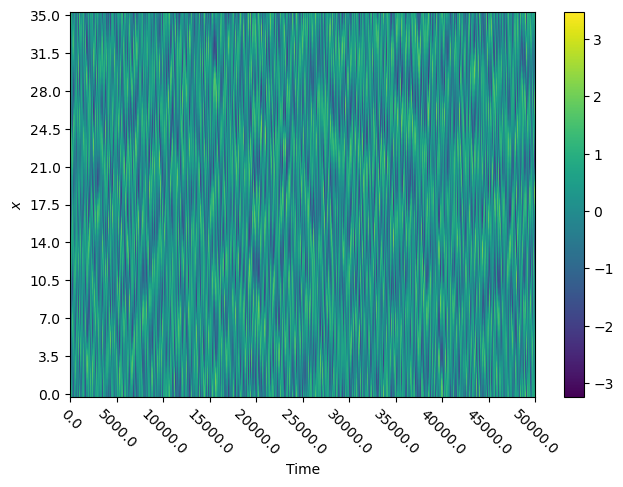

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [30],
        [30],
        [30],
        [30],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0088 - mse: 6.1892e-04 - NMSE: 0.0056 - covmat_fro_loss: 2.9237e-04 - global_gradnorm: 0.6174 - tot_time: 0h 0m 26.9s

Epoch 1: val_NMSE improved from inf to 0.00487, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 135ms/step - loss: 0.0067 - mse: 4.1130e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.4447e-04 - global_gradnorm: 0.4233 - val_loss: 0.0067 - val_mse: 4.0625e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0066 - mse: 4.0190e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.4102e-04 - global_gradnorm: 0.4025 - tot_time: 0h 2m 15.9s

Epoch 12: val_NMSE did not improve from 0.00366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 126ms/step - loss: 0.0066 - mse: 4.0190e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.4149e-04 - global_gradnorm: 0.4035 - val_loss: 0.0068 -

Epoch 23/1000
76/76 [==============================] - ETA: 0s - loss: 0.0058 - mse: 3.4101e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2374e-04 - global_gradnorm: 0.3428 - tot_time: 0h 4m 4.2s

Epoch 23: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 130ms/step - loss: 0.0058 - mse: 3.4101e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2370e-04 - global_gradnorm: 0.3427 - val_loss: 0.0061 - val_mse: 3.8005e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
76/76 [==============================] - ETA: 0s - loss: 0.0059 - mse: 3.6052e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2974e-04 - global_gradnorm: 0.3562 - tot_time: 0h 4m 13.9s

Epoch 24: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 35/1000
76/76 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.2471e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1916e-04 - global_gradnorm: 0.3177 - tot_time: 0h 6m 2.3s

Epoch 35: val_NMSE improved from 0.00328 to 0.00318, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 134ms/step - loss: 0.0054 - mse: 3.2471e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1911e-04 - global_gradnorm: 0.3178 - val_loss: 0.0057 - val_mse: 3.5328e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
76/76 [==============================] - ETA: 0s - loss: 0.0053 - mse: 3.1361e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1551e-04 - global_gradnorm: 0.3065 - tot_time: 0h 6m 12.4s

Epoch 36:

Epoch 47/1000
76/76 [==============================] - ETA: 0s - loss: 0.0051 - mse: 2.9887e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1052e-04 - global_gradnorm: 0.2866 - tot_time: 0h 8m 0.5s

Epoch 47: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 128ms/step - loss: 0.0051 - mse: 2.9887e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1080e-04 - global_gradnorm: 0.2872 - val_loss: 0.0056 - val_mse: 3.6351e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
76/76 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.0220e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1238e-04 - global_gradnorm: 0.2963 - tot_time: 0h 8m 10.3s

Epoch 48: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.8490e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0580e-04 - global_gradnorm: 0.2721 - tot_time: 0h 9m 58.3s

Epoch 59: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 127ms/step - loss: 0.0048 - mse: 2.8490e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0583e-04 - global_gradnorm: 0.2720 - val_loss: 0.0052 - val_mse: 3.3358e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.8717e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0695e-04 - global_gradnorm: 0.2843 - tot_time: 0h 10m 7.9s

Epoch 60: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 71/1000
76/76 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.8551e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0639e-04 - global_gradnorm: 0.2724 - tot_time: 0h 11m 55.8s

Epoch 71: val_NMSE did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 128ms/step - loss: 0.0047 - mse: 2.8551e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0663e-04 - global_gradnorm: 0.2732 - val_loss: 0.0055 - val_mse: 3.7299e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
76/76 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.7286e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0205e-04 - global_gradnorm: 0.2594 - tot_time: 0h 12m 5.5s

Epoch 72: val_NMSE did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.6606e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9963e-04 - global_gradnorm: 0.2471 - tot_time: 0h 13m 52.9s

Epoch 83: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 126ms/step - loss: 0.0045 - mse: 2.6606e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9953e-04 - global_gradnorm: 0.2471 - val_loss: 0.0051 - val_mse: 3.3118e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
76/76 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.6015e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9783e-04 - global_gradnorm: 0.2459 - tot_time: 0h 14m 2.6s

Epoch 84: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

76/76 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.5446e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9599e-04 - global_gradnorm: 0.2408 - tot_time: 0h 15m 50.3s

Epoch 95: val_NMSE improved from 0.00273 to 0.00272, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 133ms/step - loss: 0.0043 - mse: 2.5446e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9594e-04 - global_gradnorm: 0.2406 - val_loss: 0.0048 - val_mse: 3.0213e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
76/76 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5696e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9705e-04 - global_gradnorm: 0.2353 - tot_time: 0h 16m 0.4s

Epoch 96: val_NMSE di

Epoch 107/1000
76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.3750e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8962e-04 - global_gradnorm: 0.2109 - tot_time: 0h 17m 48.0s

Epoch 107: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 128ms/step - loss: 0.0042 - mse: 2.3750e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8967e-04 - global_gradnorm: 0.2111 - val_loss: 0.0047 - val_mse: 3.0543e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4809e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9376e-04 - global_gradnorm: 0.2287 - tot_time: 0h 17m 57.7s

Epoch 108: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.5056e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9457e-04 - global_gradnorm: 0.2289 - tot_time: 0h 19m 45.1s

Epoch 119: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 126ms/step - loss: 0.0042 - mse: 2.5056e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9459e-04 - global_gradnorm: 0.2289 - val_loss: 0.0047 - val_mse: 3.1143e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 120/1000
76/76 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3441e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8840e-04 - global_gradnorm: 0.2189 - tot_time: 0h 19m 54.8s

Epoch 120: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.3412e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8825e-04 - global_gradnorm: 0.2190 - tot_time: 0h 21m 41.5s

Epoch 131: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 129ms/step - loss: 0.0040 - mse: 2.3412e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8827e-04 - global_gradnorm: 0.2187 - val_loss: 0.0047 - val_mse: 3.0700e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 132/1000
76/76 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3851e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.9024e-04 - global_gradnorm: 0.2206 - tot_time: 0h 21m 51.3s

Epoch 132: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.3379e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8832e-04 - global_gradnorm: 0.2166 - tot_time: 0h 23m 38.9s

Epoch 143: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 131ms/step - loss: 0.0040 - mse: 2.3379e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8836e-04 - global_gradnorm: 0.2169 - val_loss: 0.0047 - val_mse: 3.2112e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 144/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.3520e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8882e-04 - global_gradnorm: 0.2121Restoring model weights from the end of the best epoch: 114.
 - tot_time: 0h 23m 48.6s

Epoch 144: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/

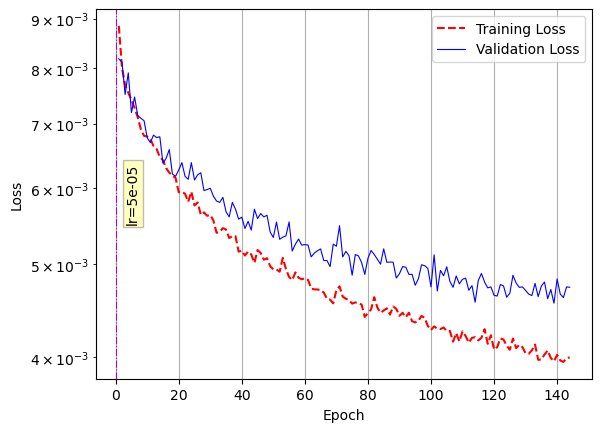

<Figure size 640x480 with 0 Axes>

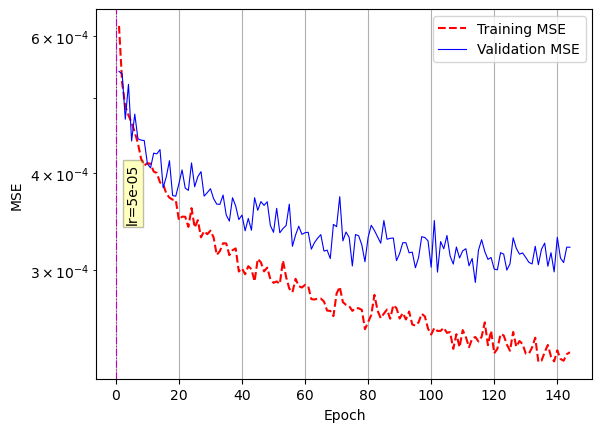

<Figure size 640x480 with 0 Axes>

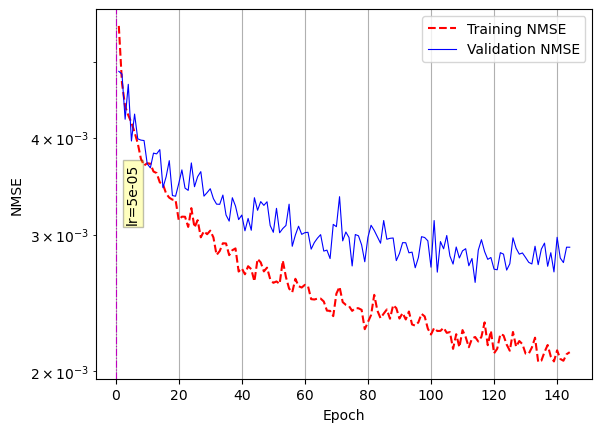

<Figure size 640x480 with 0 Axes>

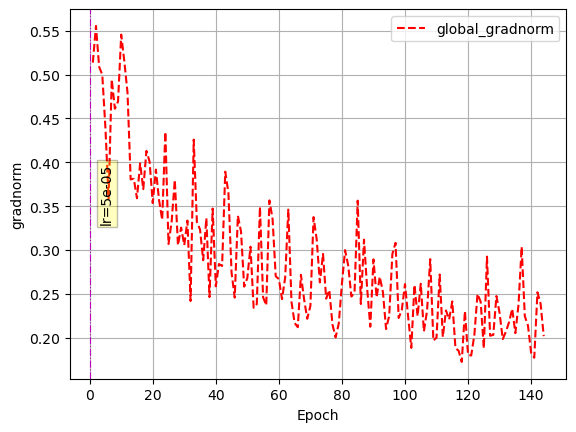



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.5


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0066 - mse: 5.7106e-04 - NMSE: 0.0051 - covmat_fro_loss: 4.9511e-04 - global_gradnorm: 0.4435 - tot_time: 0h 0m 41.2s

Epoch 1: val_NMSE improved from inf to 0.00419, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/check

Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 4.9741e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.6247e-04 - global_gradnorm: 0.4068 - tot_time: 0h 2m 45.6s

Epoch 12: val_NMSE did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 157ms/step - loss: 0.0060 - mse: 4.9741e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.6284e-04 - global_gradnorm: 0.4073 - val_loss: 0.0055 - val_mse: 4.2702e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
71/71 [==============================] - ETA: 0s - loss: 0.0061 - mse: 5.0074e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.6429e-04 - global_gradnorm: 0.4196 - tot_time: 0h 2m 56.7s

Epoch 13: val_NMSE did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 24/1000
71/71 [==============================] - ETA: 0s - loss: 0.0059 - mse: 4.8454e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.5684e-04 - global_gradnorm: 0.4052 - tot_time: 0h 5m 1.1s

Epoch 24: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 158ms/step - loss: 0.0059 - mse: 4.8454e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.5695e-04 - global_gradnorm: 0.4050 - val_loss: 0.0054 - val_mse: 4.2083e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 4.8840e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.5953e-04 - global_gradnorm: 0.4035 - tot_time: 0h 5m 12.3s

Epoch 25: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.6630e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.4787e-04 - global_gradnorm: 0.3819 - tot_time: 0h 7m 15.4s

Epoch 36: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 157ms/step - loss: 0.0058 - mse: 4.6630e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.4807e-04 - global_gradnorm: 0.3814 - val_loss: 0.0054 - val_mse: 4.1765e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.6219e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.4648e-04 - global_gradnorm: 0.3756 - tot_time: 0h 7m 26.8s

Epoch 37: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/

Epoch 48/1000
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.5938e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.4410e-04 - global_gradnorm: 0.3763 - tot_time: 0h 9m 30.4s

Epoch 48: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 158ms/step - loss: 0.0057 - mse: 4.5938e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.4429e-04 - global_gradnorm: 0.3766 - val_loss: 0.0053 - val_mse: 3.9837e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.6073e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.4626e-04 - global_gradnorm: 0.3760 - tot_time: 0h 9m 41.4s

Epoch 49: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

<Figure size 640x480 with 0 Axes>

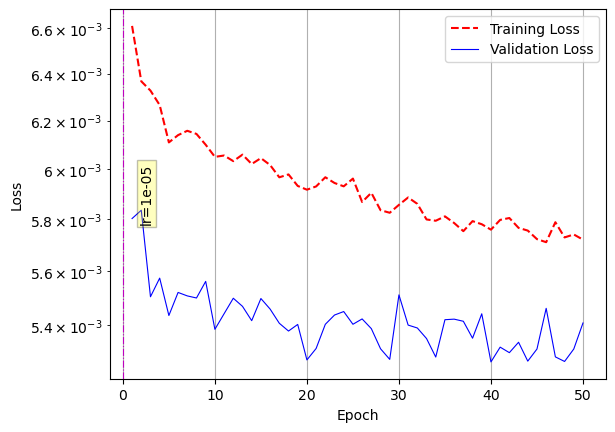

<Figure size 640x480 with 0 Axes>

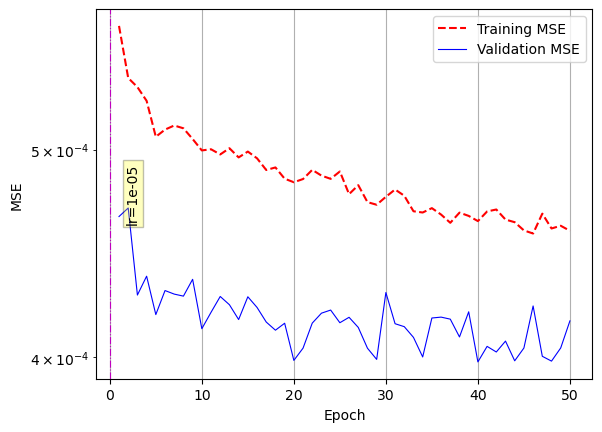

<Figure size 640x480 with 0 Axes>

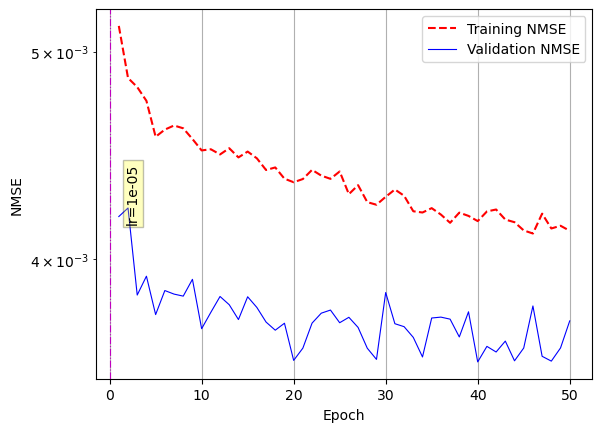

<Figure size 640x480 with 0 Axes>

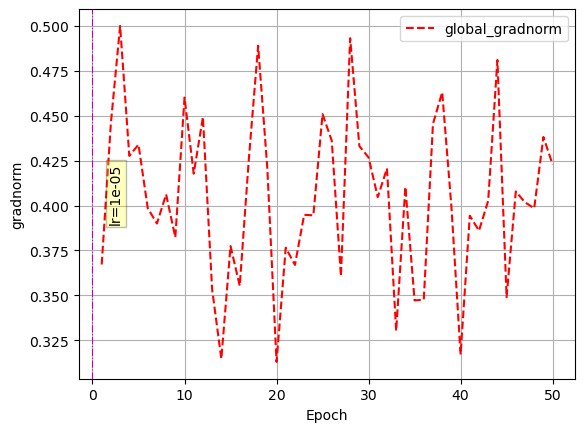



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.5


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0454 - mse: 0.0076 - NMSE: 0.0687 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.5000 - tot_time: 0h 1m 48.6s

Epoch 1: val_NMSE improved from inf to 0.02089, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/L

58/58 [==============================] - ETA: 0s - loss: 0.0412 - mse: 0.0069 - NMSE: 0.0620 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.5000 - tot_time: 0h 4m 48.8s

Epoch 12: val_NMSE did not improve from 0.02055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 285ms/step - loss: 0.0412 - mse: 0.0069 - NMSE: 0.0620 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.5000 - val_loss: 0.0166 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
58/58 [==============================] - ETA: 0s - loss: 0.0409 - mse: 0.0068 - NMSE: 0.0615 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.5000 - tot_time: 0h 5m 5.0s

Epoch 13: val_NMSE did not improve from 0.02055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesChec

Epoch 25/1000
58/58 [==============================] - ETA: 0s - loss: 0.0396 - mse: 0.0066 - NMSE: 0.0593 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.5000 - tot_time: 0h 8m 22.7s

Epoch 25: val_NMSE did not improve from 0.02055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 16s 280ms/step - loss: 0.0396 - mse: 0.0066 - NMSE: 0.0593 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.5000 - val_loss: 0.0177 - val_mse: 0.0027 - val_NMSE: 0.0241 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 26/1000
58/58 [==============================] - ETA: 0s - loss: 0.0399 - mse: 0.0066 - NMSE: 0.0598 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.5000 - tot_time: 0h 8m 39.0s

Epoch 26: val_NMSE did not improve from 0.02055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_020/checkpoints/Lo

<Figure size 640x480 with 0 Axes>

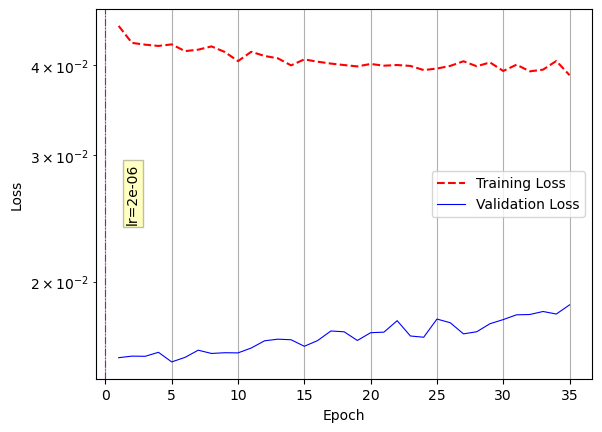

<Figure size 640x480 with 0 Axes>

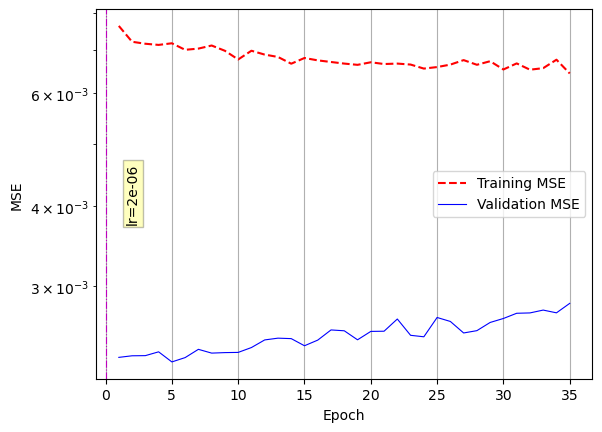

<Figure size 640x480 with 0 Axes>

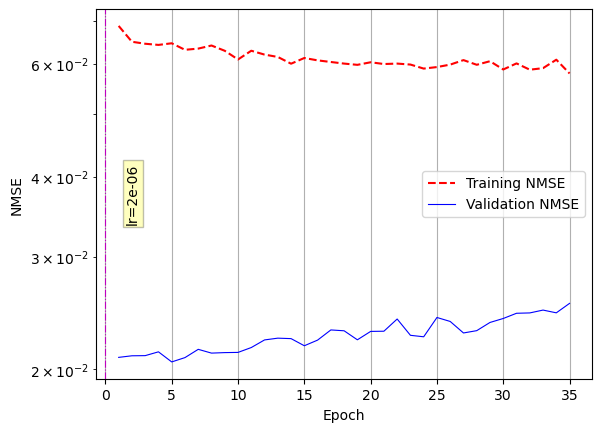

<Figure size 640x480 with 0 Axes>

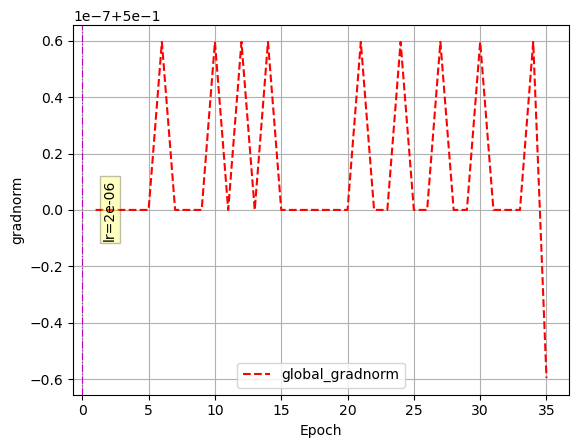



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.5


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
 1/49 [..............................] - ETA: 1:54:57 - loss: 0.1203 - mse: 0.0281 - NMSE: 0.2527 - covmat_fro_loss: 0.0073 - global_gradnorm: 0.5000

2022-12-26 12:10:17.942029: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at variable_ops.cc:118 : ALREADY_EXISTS: Resource __per_step_0/gradient_tape/rnn_11/while_50/rnn_11/while_50_grad/body/_20226/gradient_tape/rnn_11/while_50/gradients/AddN_2/tmp_var/frame:2387599132155933962/iter:1/N10tensorflow19TemporaryVariableOp6TmpVarE
2022-12-26 12:10:17.942360: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at variable_ops.cc:118 : ALREADY_EXISTS: Resource __per_step_0/gradient_tape/rnn_10/while_50/rnn_10/while_50_grad/body/_20346/gradient_tape/rnn_10/while_50/gradients/AddN_2/tmp_var/frame:2126601120143109835/iter:1/N10tensorflow19TemporaryVariableOp6TmpVarE
2022-12-26 12:10:17.942643: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at variable_ops.cc:118 : ALREADY_EXISTS: Resource __per_step_0/gradient_tape/rnn_9/while_50/rnn_9/while_50_grad/body/_20466/gradient_tape/rnn_9/while_50/gradients/AddN_2/tmp_var/frame:14285181037412647889

AlreadyExistsError: Graph execution error:

Resource __per_step_0/gradient_tape/rnn_11/while_50/rnn_11/while_50_grad/body/_20226/gradient_tape/rnn_11/while_50/gradients/AddN_2/tmp_var/frame:2387599132155933962/iter:1/N10tensorflow19TemporaryVariableOp6TmpVarE
	 [[{{node gradient_tape/rnn_11/while_50/rnn_11/while_50_grad/body/_20226/gradient_tape/rnn_11/while_50/gradients/AddN_2/tmp_var}}]] [Op:__inference_train_function_1130451]

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_GRU,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [ ]:
### Training the combined AE-RNN


# 